En el presente proyecto se procederá a desarrollar un modelo que pueda predecir si un cliente dejará o no el servicio de una empresa, junto a realizar un análisis de que medidas podrían tomarse para reducir el riesgo de fuga.

## Inicialización

### Cargar librerias

Se procede a cargar las librerías que se utilizaran en el proyecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import SelectKBest,f_classif,chi2
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report,RocCurveDisplay
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

import eli5
from eli5.sklearn import PermutationImportance

### Cargar datos

Se procede a cargar los datos.

In [2]:
data = pd.read_csv('database/Archivo data - 2023.csv')

## EDA

A continuación, procederemos a realizar una exploración sobre la base de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,30,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,1020,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,60,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,1350,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,60,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data['customerID'].nunique()

7043

In [6]:
print('Churn distribution, %:')
round(data.groupby(['Churn']).size()/data.shape[0]*100).convert_dtypes()

Churn distribution, %:


Churn
No     73
Yes    27
dtype: Int64

Podemos observar que la tasa de abandono es de un 27%, lo cual es bastante alto. Con respecto a la base de datos en sí misma, pudimos comprobar que no existen filas repetidas al comparar el número de valores únicos para "customer ID", que el tipo de dato de la columna "TotalCharges" es incorrecto y no parecen existir valores nulos. Procederemos a cambiar el tipo de datos de "TotalCharges" y eliminar la columna "customer ID" ya que a partir de este momento no entrega información relevante, posteriormente realizaremos una observación más profunda de la base de datos.

In [7]:
data = data.drop(['customerID'], axis=1)

In [8]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

### Valores perdidos y cardinalidad

Definiremos una función para analizar la proporción de valores únicos, valores nulos, valores iguales a cero y valores ausentes que existen en cada columna.

In [9]:
def column_analysis(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        empty = round((data[col] == '').sum()/data.shape[0]*100,1)
        df = pd.concat([df, pd.DataFrame([col, len(unique_values), nans, zeros, empty]).T], ignore_index=True)
    return df.rename(columns = {0: 'variable', 1: 'únicos', 2: 'Nan %', 3: 'zeros %', 4: 'ausente'})

In [10]:
column_analysis(data)

,variable,únicos,Nan %,zeros %,ausente
0,gender,2,0.0,0.0,0.0
1,SeniorCitizen,2,0.0,83.8,0.0
2,Partner,2,0.0,0.0,0.0
3,Dependents,2,0.0,0.0,0.0
4,tenure,73,0.0,0.2,0.0
5,PhoneService,2,0.0,0.0,0.0
6,MultipleLines,3,0.0,0.0,0.0
7,InternetService,3,0.0,0.0,0.0
8,OnlineSecurity,3,0.0,0.0,0.0
9,OnlineBackup,3,0.0,0.0,0.0


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,971.134460,736.784431,0.00,270.00,870.000,1650.0000,2160.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


Podemos apreciar que en las variables categóricas los valores poseen una baja cardinalidad, lo cual es positivo para la elaboración del modelo. Después de haber realizado el cambio de tipo de dato en la columna "TotalCharges" aparecieron algunas columnas con valores nulos lo cual indica que estos eran datos vacíos que no era posible apreciar cuando el tipo de dato de esta columna era object. Por el lado de los valores iguales a cero podemos observar que en la columna binaria "SeniorCitizen" existe un desbalance a favor de los ceros, mientras que la columna "tenure" también posee valores de cero. Finalmente, con respecto a variables que se encuentren ausentes, es decir se representen como un espacio en blanco, no poseemos ninguna entre las columnas de la base de datos.

Procedermos a observar las filas con valores nulos y valores de "tenure" iguales a cero.

In [12]:
data[data['tenure']==0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [13]:
data.index[data['tenure']==0].tolist()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [14]:
data.index[data['TotalCharges'].isnull()].tolist()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

Al observar las filas con "tenure" igual a cero notamos que coincidentemente son las mismas filas que presentan los valores nulos en la columna "TotalCharges", esto podría indicar que son clientes recientemente ingresados al servicio y por ende no poseen antigüedad en el mismo ni se les han hecho cargos por los servicios, presentando el valor de cargo mensual el cual debiera ser lo que pagaran a futuro. Procederemos a eliminar estas filas ya que, al ser una cantidad tan reducida, alrededor de un 0,2% de los datos, no afectaran a los resultados obtenidos y en caso de ser clientes nuevos no aportarán a la investigación que se quiere realizar.

In [15]:
data.dropna(inplace = True)

### Funciones

Procederemos a crear una serie de funciones para el análisis exploratorio de los datos y el modelado.

In [16]:
def proportion_bin(feature,result_1,result_2):
    result_a = data[data[feature]==result_1]
    result_b = data[data[feature]==result_2]
    a_yes = result_a[result_a['Churn']=='Yes']
    a_no = result_a[result_a['Churn']=='No']
    b_yes = result_b[result_b['Churn']=='Yes']
    b_no = result_b[result_b['Churn']=='No']
    prop_a = round(a_yes[feature].count()/a_no[feature].count(),3)
    prop_b = round(b_yes[feature].count()/b_no[feature].count(),3)
    return print(f"{feature}: Proporción de abandono en clase {result_1}: {prop_a} vs clase {result_2}: {prop_b}")

In [17]:
def proportion_tri(feature,result_1,result_2,result_3):
    result_a = data[data[feature]==result_1]
    result_b = data[data[feature]==result_2]
    result_c = data[data[feature]==result_3]
    a_yes = result_a[result_a['Churn']=='Yes']
    a_no = result_a[result_a['Churn']=='No']
    b_yes = result_b[result_b['Churn']=='Yes']
    b_no = result_b[result_b['Churn']=='No']
    c_yes = result_c[result_c['Churn']=='Yes']
    c_no = result_c[result_c['Churn']=='No']    
    prop_a = round(a_yes[feature].count()/a_no[feature].count(),3)
    prop_b = round(b_yes[feature].count()/b_no[feature].count(),3)
    prop_c = round(c_yes[feature].count()/c_no[feature].count(),3)
    return print(f"{feature}: Proporción de abandono en clase {result_1}: {prop_a} vs clase {result_2}: {prop_b} vs clase {result_3}: {prop_c}")

In [18]:
def heat_map(feature_1, feature_2):
    result = pd.pivot_table(data=data, index=feature_1, columns=feature_2,values='Churn')
    sns.heatmap(result, annot=True, cmap = 'RdYlGn_r').set_title(f"¿Como '{feature_1}' y '{feature_2}' afectan la fuga?")
    plt.show()

In [19]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    RocCurveDisplay.from_estimator(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()


In [20]:
def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

Agruparemos las columnas en distintas temáticas para su posterior análisis.

In [21]:
personal = ['gender','SeniorCitizen','Partner','Dependents']
services = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']
payment = ['Contract','PaperlessBilling','PaymentMethod']
numerical = ['tenure','MonthlyCharges','TotalCharges']

### Grupo 1: Información Personal

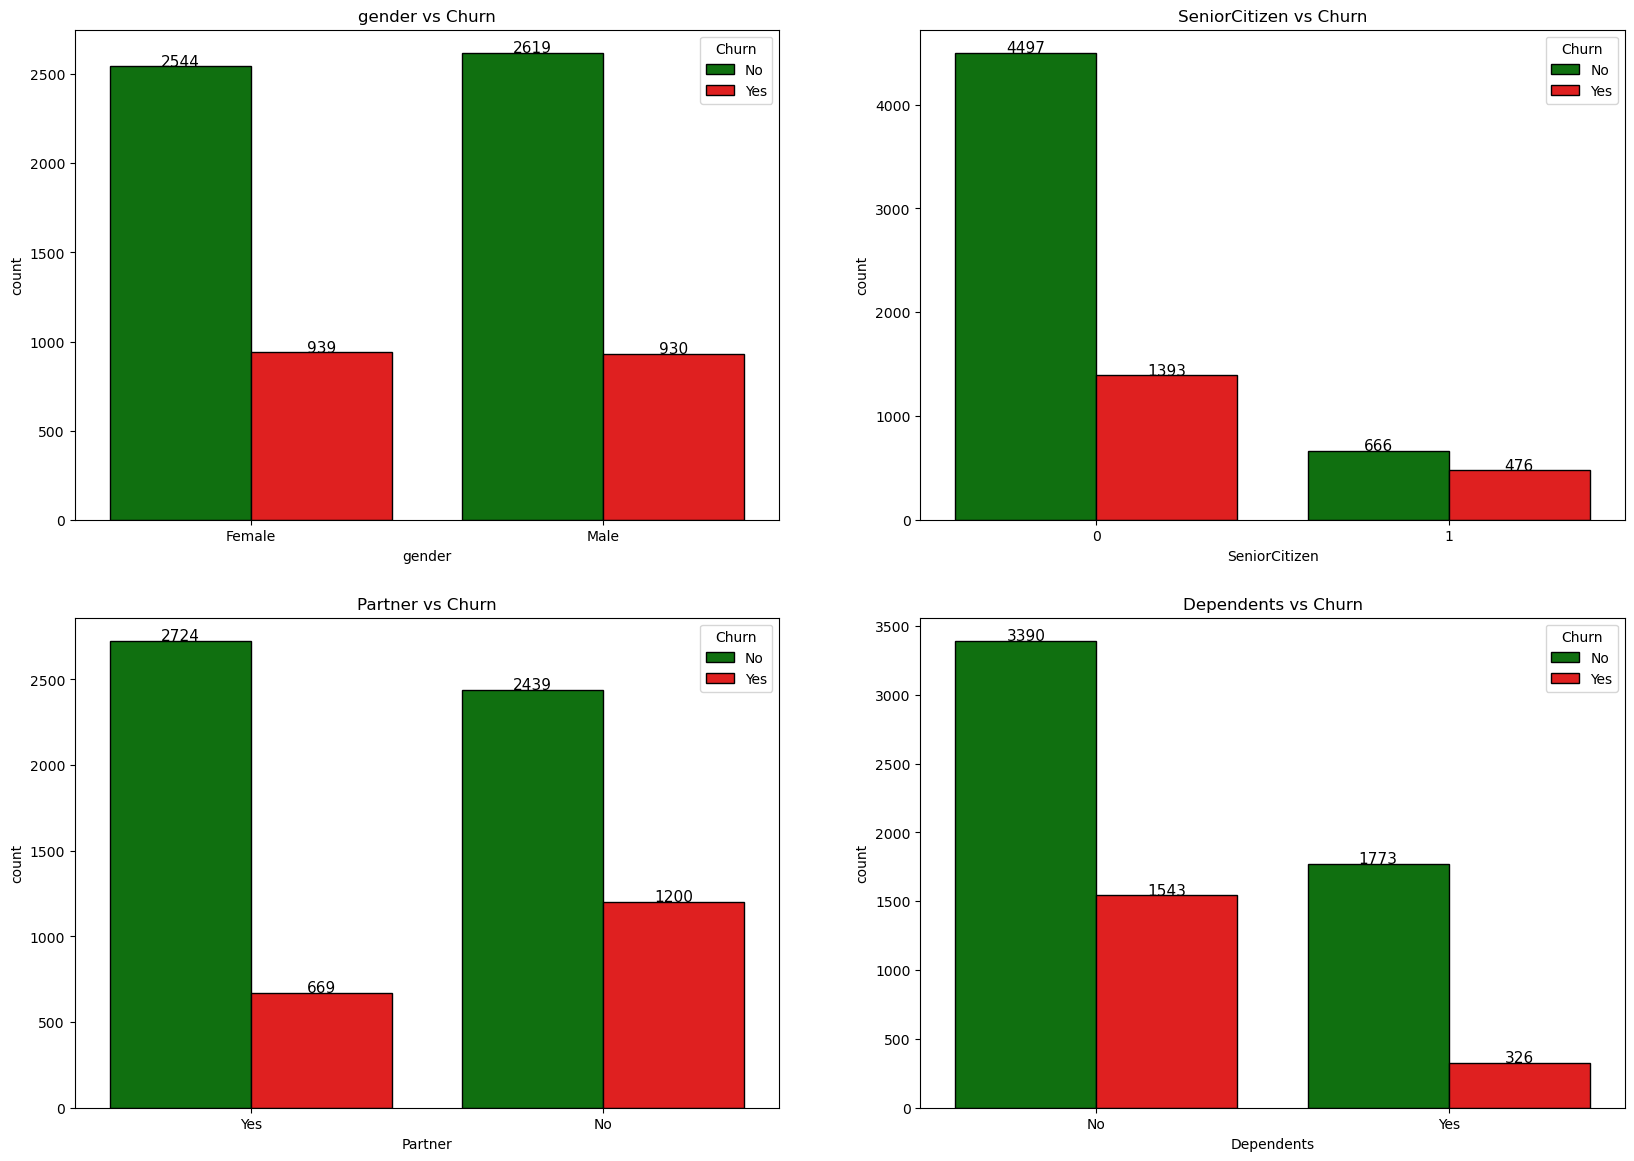

In [22]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(personal)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x=personal[i],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = personal[i] + ' vs Churn'
    plt.title(title);
plt.show()

In [23]:
proportion_bin('gender', 'Female', 'Male')
proportion_bin('SeniorCitizen', 0, 1)
proportion_bin('Partner', 'Yes', 'No')
proportion_bin('Dependents', 'No', 'Yes')

gender: Proporción de abandono en clase Female: 0.369 vs clase Male: 0.355
SeniorCitizen: Proporción de abandono en clase 0: 0.31 vs clase 1: 0.715
Partner: Proporción de abandono en clase Yes: 0.246 vs clase No: 0.492
Dependents: Proporción de abandono en clase No: 0.455 vs clase Yes: 0.184


Podemos apreciar que la tasa de fuga para hombres y mujeres es prácticamente la misma, lo que nos podría indicar que la fuga se puede considerar independiente del género de la persona. 

Con respecto al resto de las columnas del grupo, en todas ellas podemos ver que existe una característica con mayor ratio de fuga. Para el caso de la tercera edad, columna que posee una distribución desbalanceada en favor de la gente que no pertenece a la tercera edad, podemos apreciar que los que si pertenecen a este grupo tienen más del doble de probabilidad de abandonar los servicios. Para el caso de las parejas, las personas que no poseen pareja tienen el doble de probabilidad de abandonar el uso de los servicios, mientras que las personas que tienen dependientes tienen 3 veces menos probabilidades de abandonar el servicio en relación a los que no poseen dependientes.

### Grupo 2: Servicios

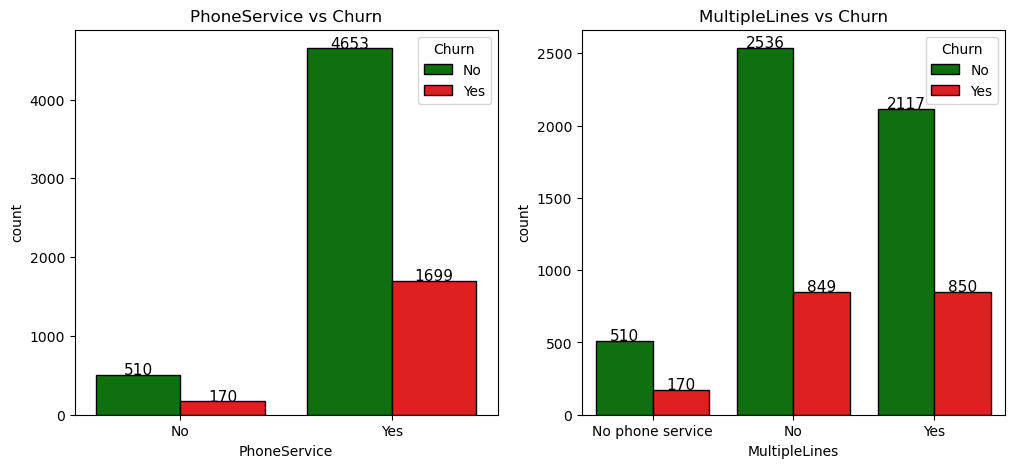

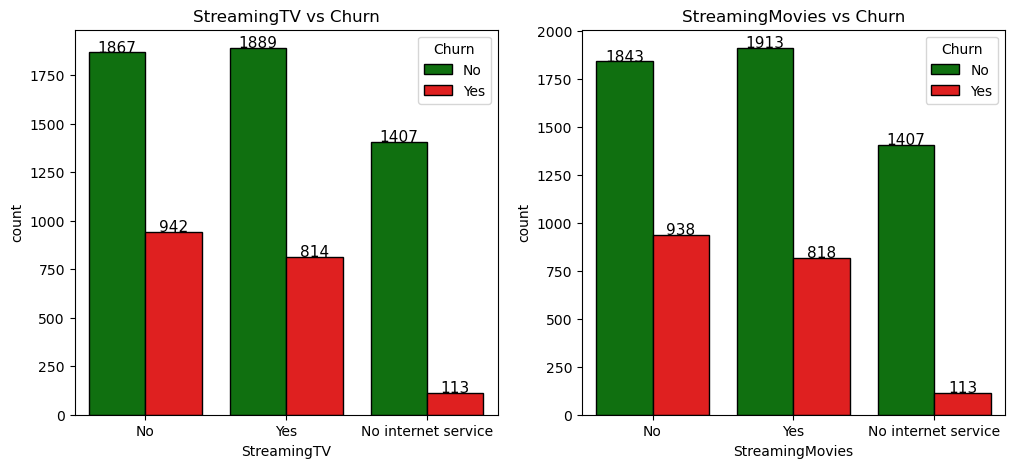

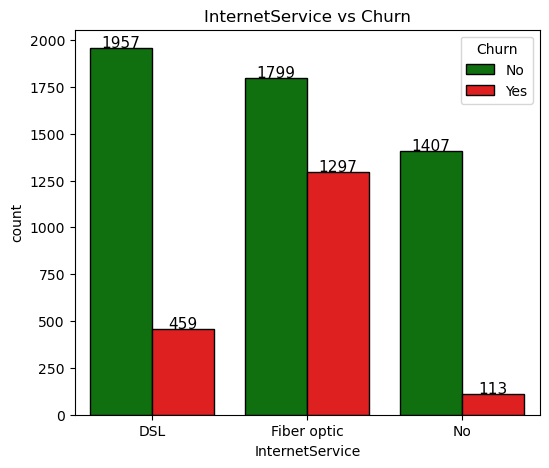

In [24]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(services[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x=services[i],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = services[i] + ' vs Churn'
    plt.title(title);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(services[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x=services[i + 3],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = services[i + 3] + ' vs Churn'
    plt.title(title);    
    
fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.countplot(x=services[2],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = services[2] + ' vs Churn'
plt.title(title);
    

plt.show()

In [25]:
proportion_bin('PhoneService', 'No', 'Yes')
proportion_tri('MultipleLines','No phone service','No','Yes')
proportion_tri('StreamingTV','No','Yes','No internet service')
proportion_tri('StreamingMovies','No','Yes','No internet service')
proportion_tri('InternetService','DSL','Fiber optic','No')

PhoneService: Proporción de abandono en clase No: 0.333 vs clase Yes: 0.365
MultipleLines: Proporción de abandono en clase No phone service: 0.333 vs clase No: 0.335 vs clase Yes: 0.402
StreamingTV: Proporción de abandono en clase No: 0.505 vs clase Yes: 0.431 vs clase No internet service: 0.08
StreamingMovies: Proporción de abandono en clase No: 0.509 vs clase Yes: 0.428 vs clase No internet service: 0.08
InternetService: Proporción de abandono en clase DSL: 0.235 vs clase Fiber optic: 0.721 vs clase No: 0.08


Al observar el servicio de telefonía, podemos notar que existe una tasa de fuga similar tanto en las personas que poseen como las que no poseen este servicio, de igual manera se aprecia esta proporción con las múltiples líneas de teléfono existiendo una taza similar para las personas con una línea, múltiples líneas o ninguna línea. Lo anterior podría indicarnos que estas columnas no están directamente relacionadas con la fuga de clientes.

Con respecto a los servicios de streaming, el comportamiento del servicio de tv es prácticamente idéntico al de películas y la presencia o ausencia de ambos para la gente que posee servicio de internet no parece influir en su ratio de fuga, existiendo muy poca diferencia entre ambos ratios.

Finalmente, los clientes del servicio de fibra óptica tienen una mucho mayor tendencia a abandonar el servicio que los que no poseen servicio de internet o poseen DSL.

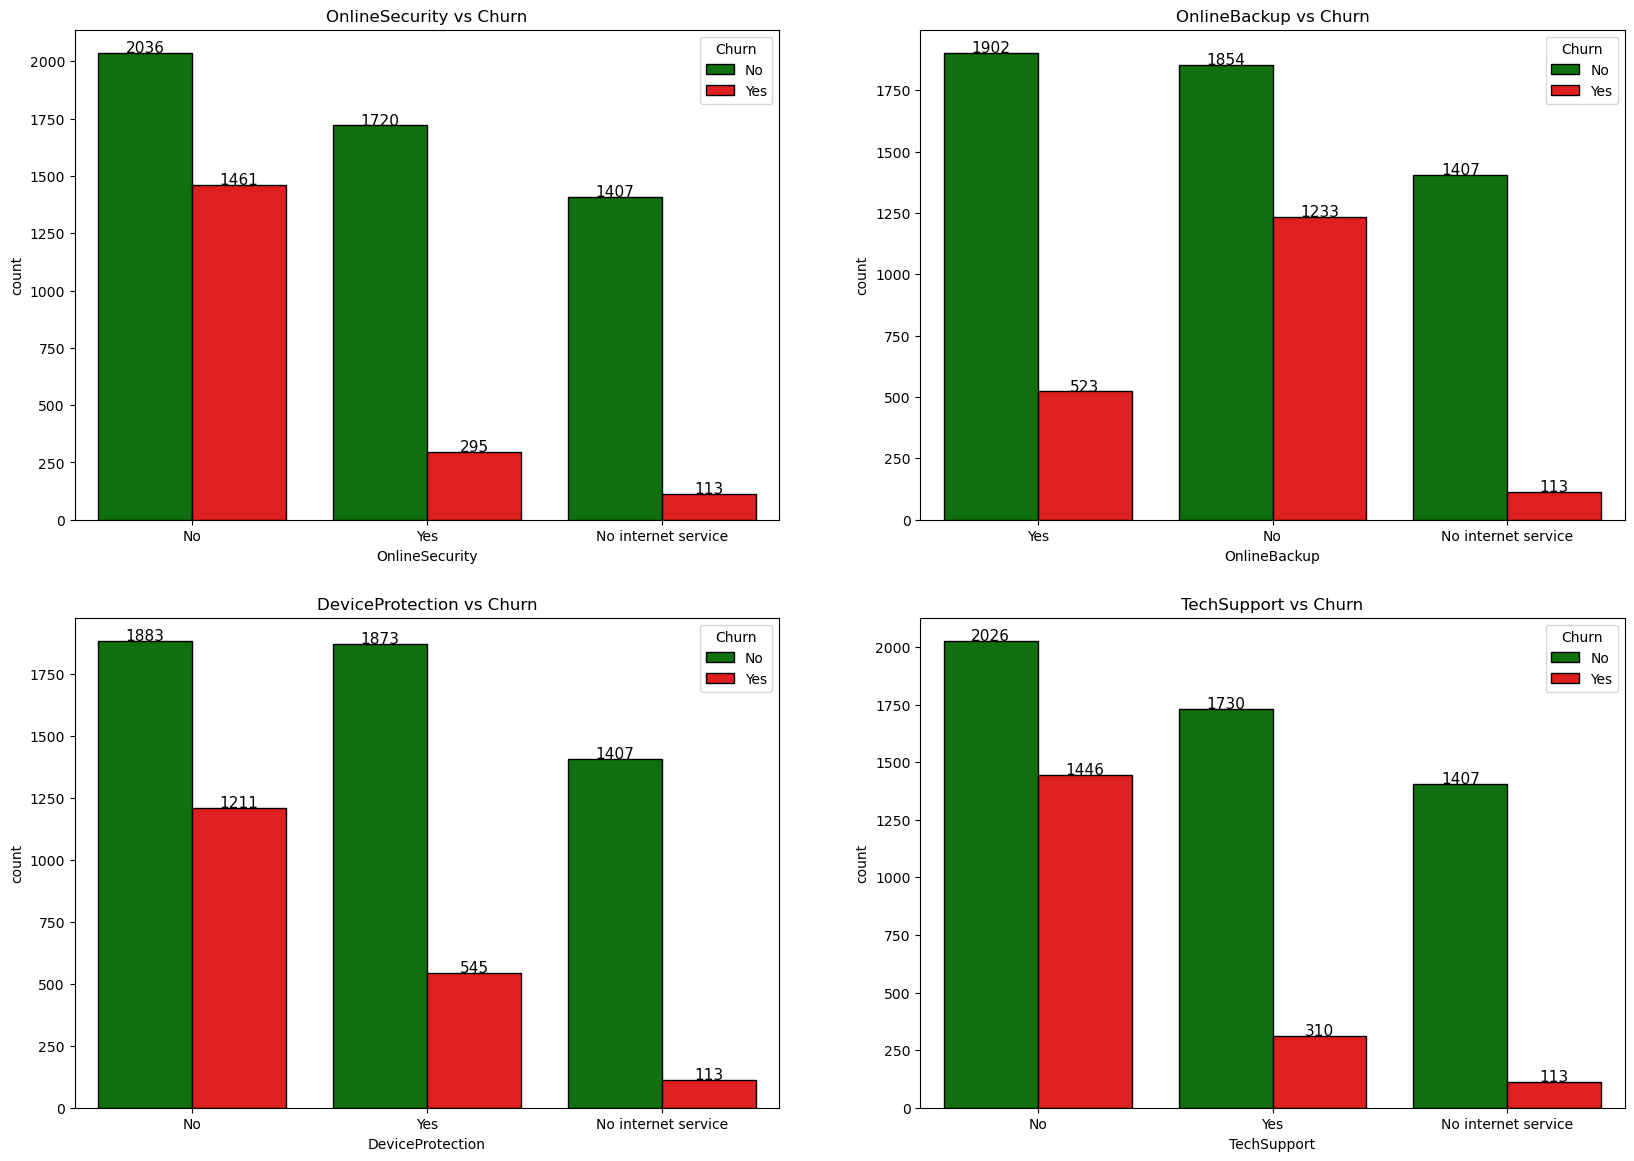

In [26]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(services[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.countplot(x=services[-4 + i],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = services[-4 + i] + ' vs Churn'
    plt.title(title);
plt.show()

In [27]:
proportion_tri('OnlineSecurity','No','Yes','No internet service')
proportion_tri('OnlineBackup','Yes','No','No internet service')
proportion_tri('DeviceProtection','No','Yes','No internet service')
proportion_tri('TechSupport','No','Yes','No internet service')

OnlineSecurity: Proporción de abandono en clase No: 0.718 vs clase Yes: 0.172 vs clase No internet service: 0.08
OnlineBackup: Proporción de abandono en clase Yes: 0.275 vs clase No: 0.665 vs clase No internet service: 0.08
DeviceProtection: Proporción de abandono en clase No: 0.643 vs clase Yes: 0.291 vs clase No internet service: 0.08
TechSupport: Proporción de abandono en clase No: 0.714 vs clase Yes: 0.179 vs clase No internet service: 0.08


Podemos apreciar en general que, para los servicios de seguridad, respaldo, protección y soporte online, los usuarios que no poseen estos servicios, teniendo un servicio de internet contratado, poseen una taza de fuga mucho mayor a los que si los poseen, por lo cual se puede deducir que estos servicios poseen importancia en la retención de los clientes.

### Grupo 3: Pagos

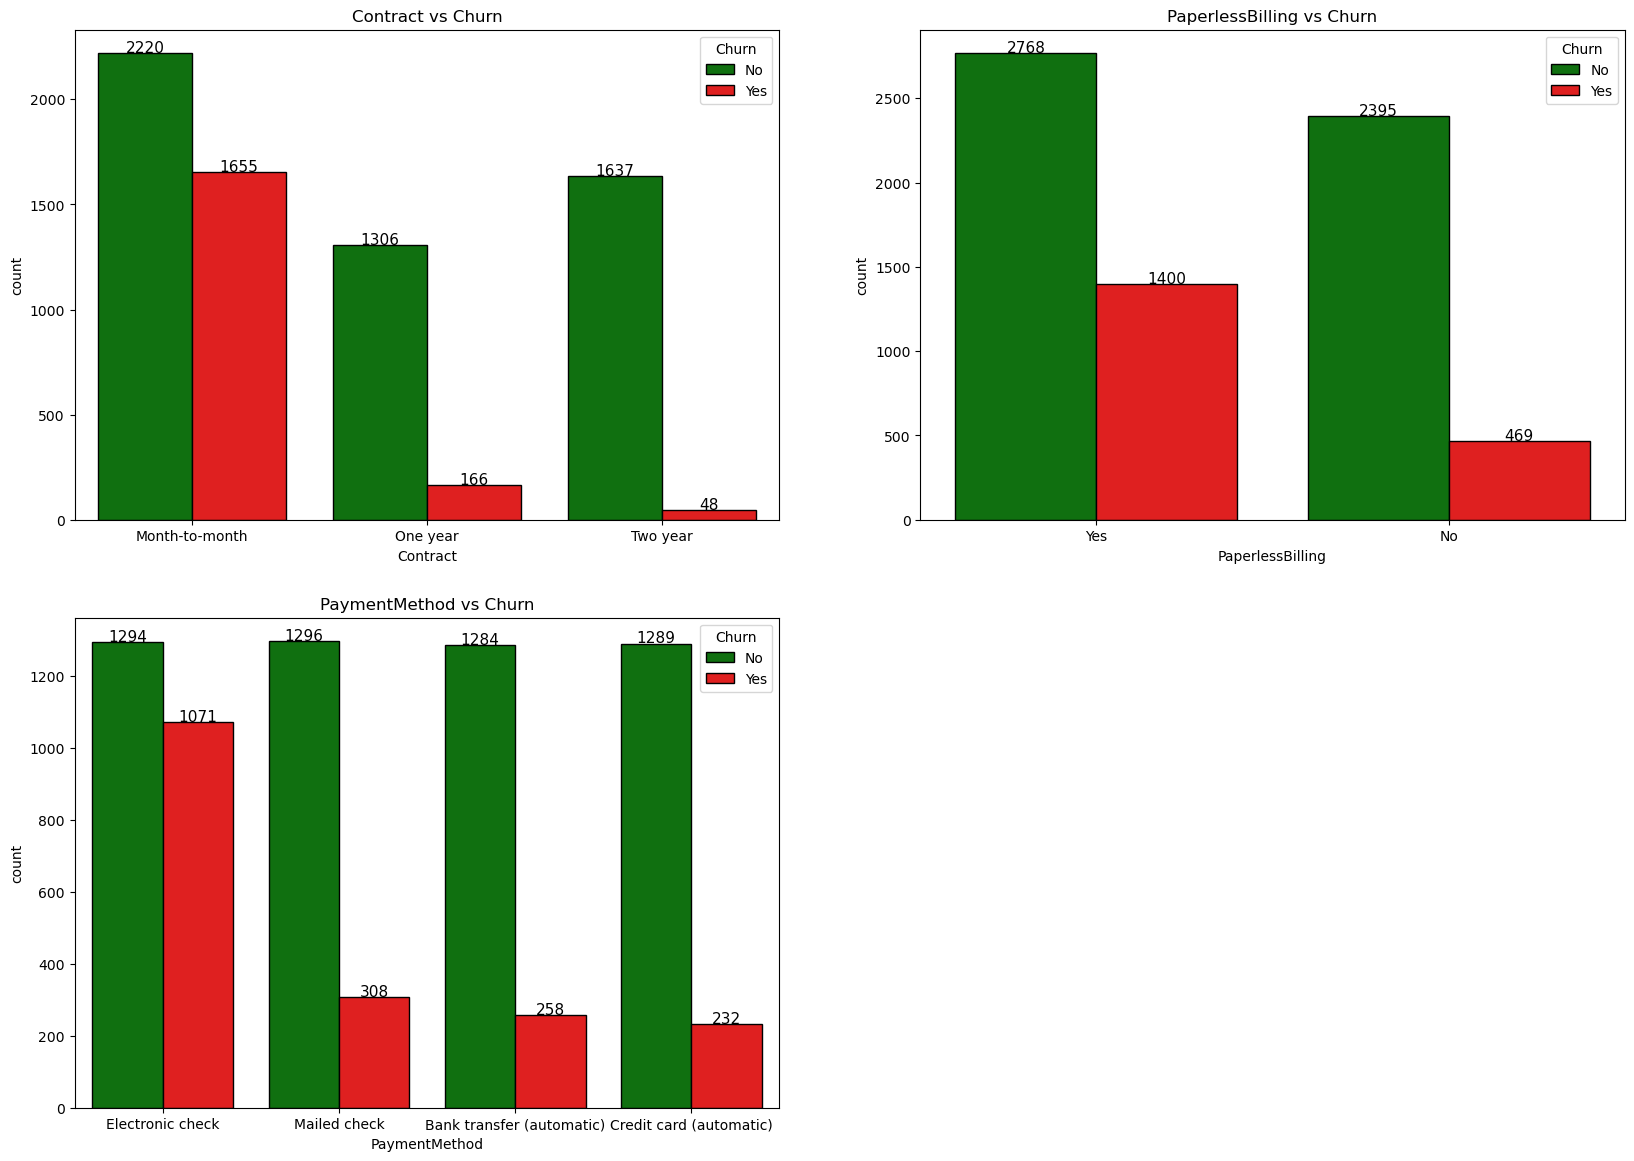

In [28]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (20,14))
for i in range(len(payment)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x=payment[i],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = payment[i] + ' vs Churn'
    plt.title(title);
plt.show()

In [29]:
proportion_tri('Contract','Month-to-month','One year','Two year')
proportion_bin('PaperlessBilling', 'Yes', 'No')

Contract: Proporción de abandono en clase Month-to-month: 0.745 vs clase One year: 0.127 vs clase Two year: 0.029
PaperlessBilling: Proporción de abandono en clase Yes: 0.506 vs clase No: 0.196


Podemos apreciar que claramente los contratos que se pagan mes a mes tienen una tasa de abandono mucho mayor que cualquier otro tipo de contrato, lo que podría explicarse porque al pagarse mes a mes el servicio es de mayor facilidad el cambiarse a otro proveedor, mientras que con pagos de una vez al año o cada dos años la persona queda "amarrada" al servicio por un mayor tiempo. Con respecto a la tenencia de factura de futura electrónica, los que poseen este servicio tienen una taza mayor de abandono que los que no lo poseen. Finalmente, la chequera electrónica tiene una taza de abandono mucho mayor a cualquier otro tipo de pago, por lo que podría analizarse el mejorar este sistema o simplemente eliminarlo.

### Columnas Numéricas

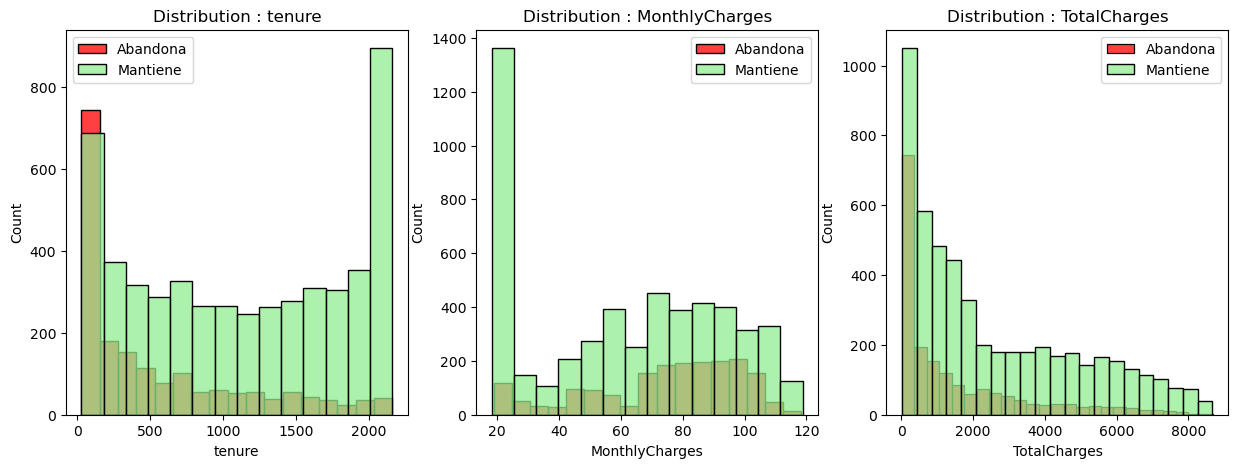

In [30]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(len(numerical)):
    abandono = data[data['Churn']=="Yes"]
    mantiene = data[data['Churn']=="No"]    
    plt.subplot(1,3,i+1)
    sns.histplot(abandono[numerical[i]], color="red", label="Abandona")
    sns.histplot(mantiene[numerical[i]], color="lightgreen", label="Mantiene")
    title = 'Distribution : ' + numerical[i]
    plt.title(title)
    plt.legend()
plt.show()

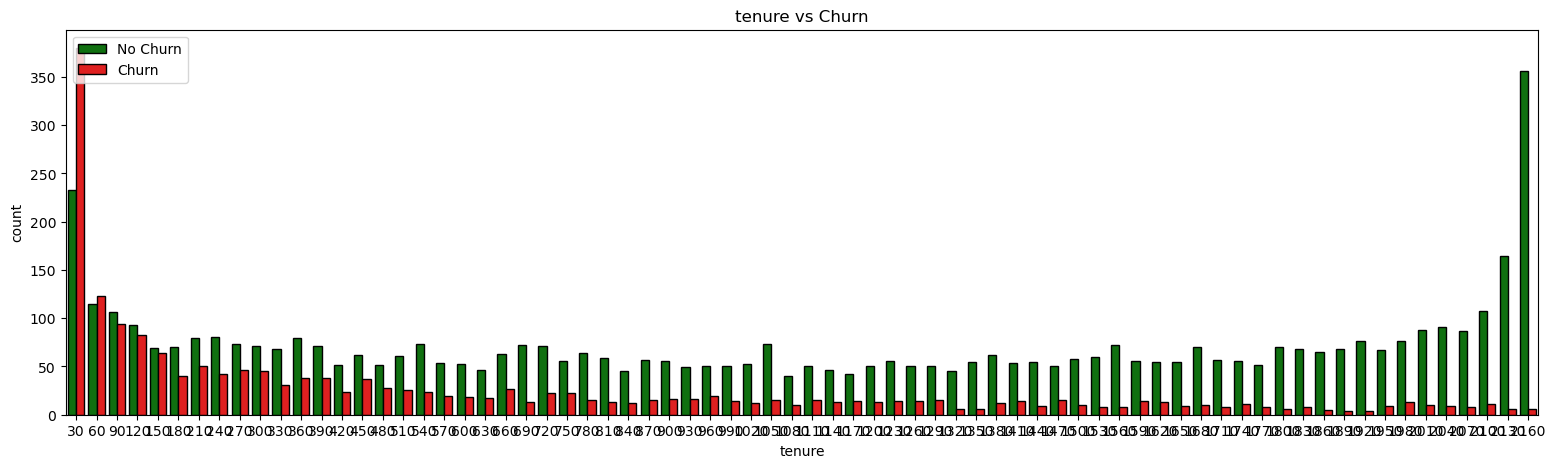

In [31]:
fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (19,5))
sns.countplot(x=numerical[0],data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
plt.legend(['No Churn','Churn'],loc = 'upper left')
title = numerical[0] + ' vs Churn'
plt.title(title);

Analizando las columnas numéricas podemos observar que en general presentan una distribución bimodal y sesgada. Con respecto a la antigüedad del cliente en días, la mayor tasa de fuga se da en los clientes más nuevos y que al pasar cierto limite de tiempo, alrededor del primer mes, la tasa de fuga disminuye drásticamente. Por la parte de los cargos mensuales podemos ver un rango de precio, entre los 70 y 110, en los cuales se concentra la mayor frecuencia de abandono por parte del cliente. Finalmente, en el caso del cobro total al cliente, la mayor cantidad de abandono se concentra en los clientes a los que se ha realizado el menor cobro, lo que corroboraría el primer grafico siendo estos clientes que no llevan mucho tiempo con el servicio.

### Análisis Multivariado

In [32]:
data['Churn'] = data['Churn'].map( {'No': 0, 'Yes': 1} ).astype(int)

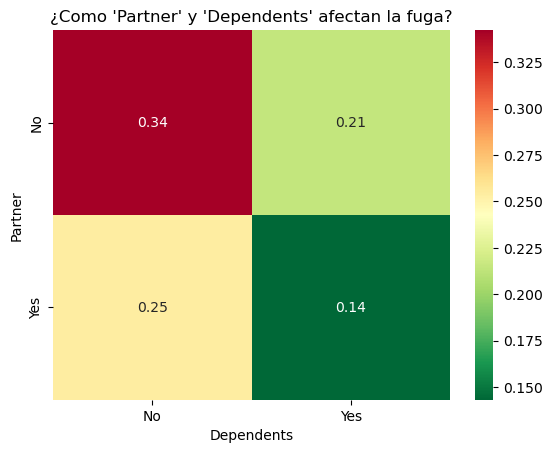

In [33]:
heat_map('Partner','Dependents')

Al comparar las variables pareja y dependientes con respecto a la fuga, podemos notar claramente que la gente soltera y sin nadie a cargo tiene un mucho mayor riesgo de fuga ante la gente con pareja y dependientes, lo anterior nos muestra la existencia de una clara correlación entre estas características y la fuga.

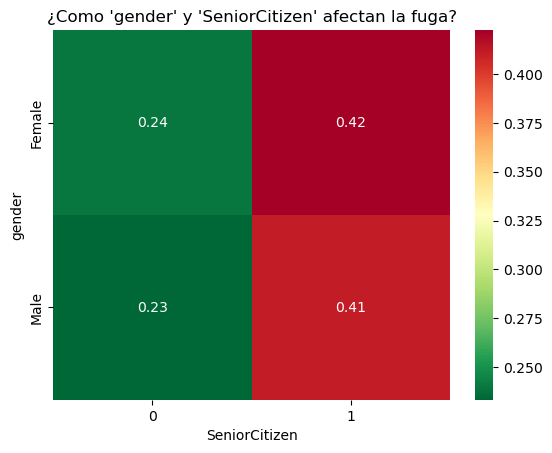

In [34]:
heat_map('gender','SeniorCitizen')

Al observar el grafico de gender y SeniorCitizen versus fuga, notamos nuevamente que el género de la persona no afecta la decisión de abandonar la empresa, mientras que el pertenecer a la tercera edad si parece ser un factor decisivo en la decisión.

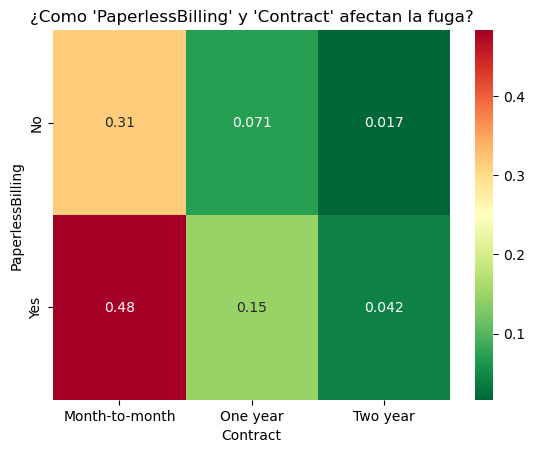

In [35]:
heat_map('PaperlessBilling','Contract')

Con respecto al pago del servicio, nuevamente podemos notar que el pago mes a mes es un punto decisivo en la fuga de clientes vs las otras modalidades de pago, y con respecto al tipo de pago se corrobora la chequera electrónica como el que más fugas atrae, teniendo la combinación de ambas opciones un ratio de fuga superior a un 50%.

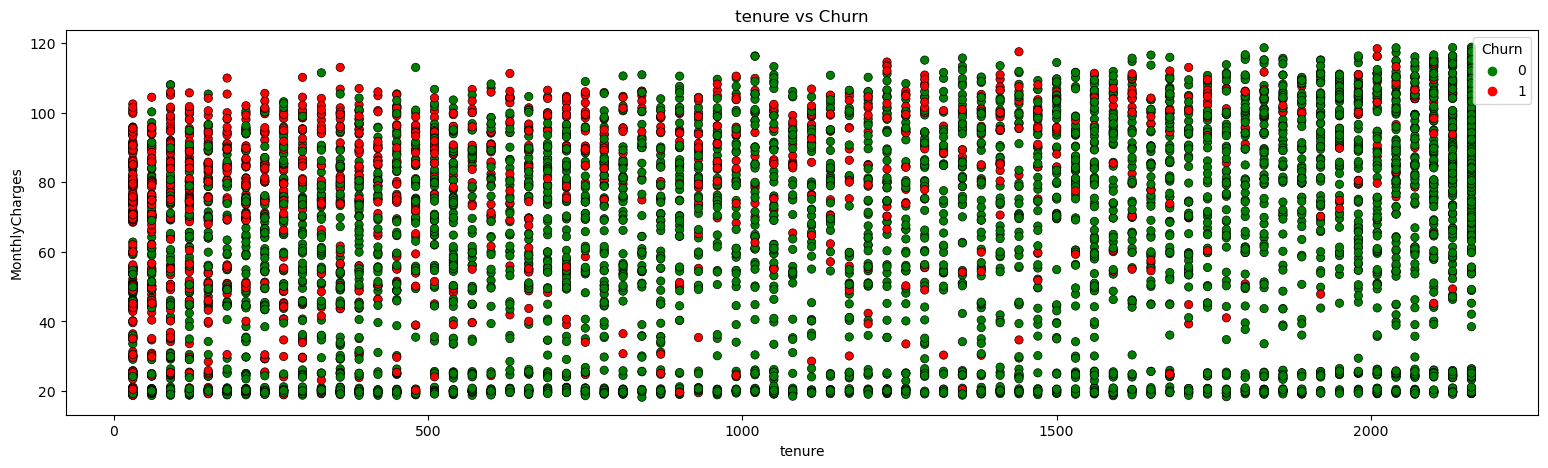

In [36]:
fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (19,5))
sns.scatterplot(x = 'tenure',y = 'MonthlyCharges',data = data,hue = 'Churn',edgecolor = 'black',palette=['green', 'red']);
title = 'tenure vs Churn'
plt.title(title);

Al observar el gasto mensual versus la antigüedad del cliente, podemos apreciar para un mismo gasto mensual al tener los clientes una mayor antigüedad disminuye la cantidad de clientes que dejan la compañía.

### Nuevas Características 

Procederemos a crear una nueva columna para enriquecer la base de datos, consistirá en agrupar a los clientes por cuantos años llevan con el servicio.

In [37]:
data.loc[data['tenure'].between(0, 365, 'both'), 'TenureBin'] = '0-1 year' 
data.loc[data['tenure'].between(365, 730, 'right'), 'TenureBin'] = '1-2 years' 
data.loc[data['tenure'].between(730, 1095, 'right'), 'TenureBin'] = '2-3 years'
data.loc[data['tenure'].between(1095, 1460, 'right'), 'TenureBin'] = '3-4 year' 
data.loc[data['tenure'].between(1460, 1825, 'right'), 'TenureBin'] = '4-5 years' 
data.loc[data['tenure'].between(1825, 2190, 'right'), 'TenureBin'] = '5-6 years'

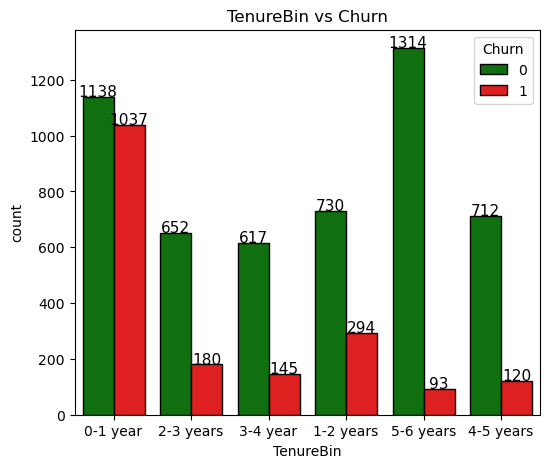

In [38]:
fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))
plt.subplot(1,1,1)
ax = sns.countplot(x='TenureBin',data = data,hue = "Churn",edgecolor = 'black',palette=['green', 'red'])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = 'TenureBin' + ' vs Churn'
plt.title(title);

plt.show()

## Preprocesamiento

Procederemos a transformar los catos categóricos a datos numéricos.

In [39]:
le = LabelEncoder()

df1 = data.copy(deep = True)
text_data_features = [i for i in list(data.columns) if i not in list(data.describe().columns)]

for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])

Procedemos a realizar un escalado de los datos, optamos por la normalización ya que las columnas a escalar presentan una distribucion bimodal y sesgada.

In [40]:
mms = MinMaxScaler()

df1['tenure'] = mms.fit_transform(df1[['tenure']])
df1['MonthlyCharges'] = mms.fit_transform(df1[['MonthlyCharges']])
df1['TotalCharges'] = mms.fit_transform(df1[['TotalCharges']])
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBin
0,0,0,1,0,0.000000,0,1,0,0,2,...,0,0,0,0,1,2,0.115423,0.001275,0,0
1,1,0,0,0,0.464789,1,0,0,2,0,...,0,0,0,1,0,3,0.385075,0.215867,0,2
2,1,0,0,0,0.014085,1,0,0,2,2,...,0,0,0,0,1,3,0.354229,0.010310,1,0
3,1,0,0,0,0.619718,0,1,0,2,0,...,2,0,0,1,0,0,0.239303,0.210241,0,3
4,0,0,0,0,0.014085,1,0,1,0,0,...,0,0,0,0,1,2,0.521891,0.015330,1,0


### Selección de características categóricas

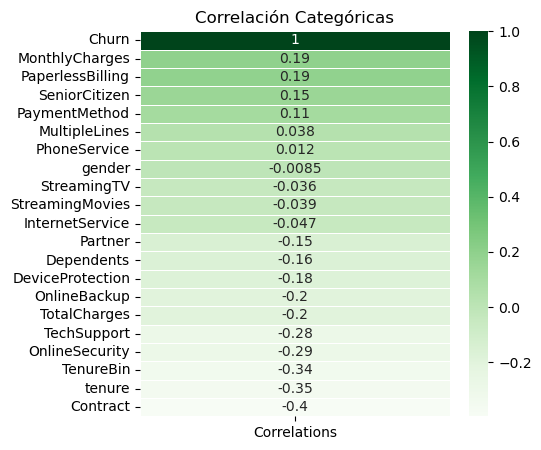

In [41]:
corr = df1.corrwith(df1['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.6, cmap="Greens");
plt.title('Correlación Categóricas');

Podemos observar que las columnas "MultipleLines", "Phone Service", "gender", "StreamingTV", "StreamingMovies" y "InternetService" presentan una muy baja correlación con "Churn" tal como se observaba en el EDA.

Procederemos a crear dos listados separando las variables categóricas y numéricas para posteriormente realizar una prueba chi-cuadrado a las variables categóricas.

In [42]:
col = list(df1.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 10:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

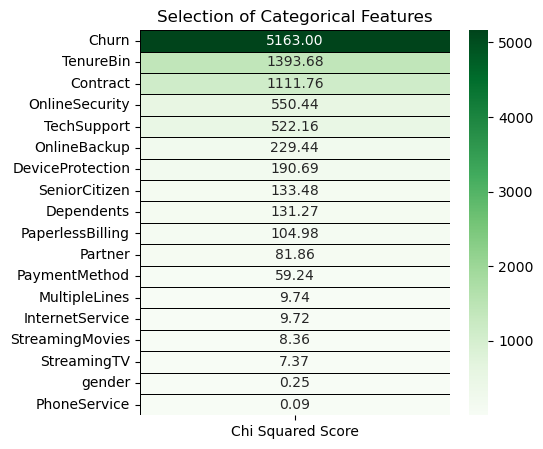

In [43]:
features = df1.loc[:,categorical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f', cmap="Greens");
plt.title('Selection of Categorical Features');

Al realizar una prueba chi-cuadrado podemos corroborar la poca relación entre las columnas anteriormente mencionadas y "Churn", por lo que procederemos a eliminarlas

In [44]:
df1.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)

### Selección de características numéricas 

Ahora procederemos a realizar una prueba ANOVA a las características numéricas.

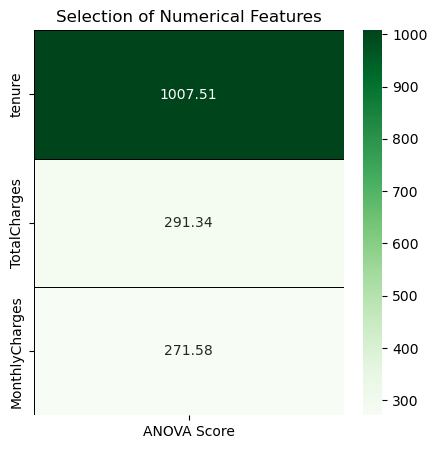

In [45]:
features = df1.loc[:,numerical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f', cmap="Greens");
plt.title('Selection of Numerical Features');

Realizando una prueba Anova, podemos concluir que las tres variables numéricas son importantes y deben mantenerse. Finalmente observaremos como quedo nuestra base de datos.

In [46]:
df1.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBin
0,0,1,0,0.000000,0,2,0,0,0,1,2,0.115423,0.001275,0,0
1,0,0,0,0.464789,2,0,2,0,1,0,3,0.385075,0.215867,0,2
2,0,0,0,0.014085,2,2,0,0,0,1,3,0.354229,0.010310,1,0
3,0,0,0,0.619718,2,0,2,2,1,0,0,0.239303,0.210241,0,3
4,0,0,0,0.014085,0,0,0,0,0,1,2,0.521891,0.015330,1,0


## Balance

Procederemos a realizar un balance de los datos, debido a que la cantidad de datos no es tan grande realizaremos un sobremuestreo.

In [47]:
over = SMOTE(sampling_strategy = 1)

f1 = df1.iloc[:,:13].values
t1 = df1.iloc[:,13].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)

Counter({0: 5163, 1: 5163})

## Modelo

Comenzaremos dividiendo los datos

In [48]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.25, random_state = 1234)

Procederemos a elaborar un modelo de ensamble. Como métrica principal para evaluar el modelo utilizaremos roc_auc ya que es una buena medida para evaluar el performance del modelo, en segundo plano consideraremos el recall al importarnos principalmente disminuir los falsos negativos, es decir la gente que va a abandonar el servicio pero que es predicha como que se mantiene en el mismo. Para realizar el modelo entrenaremos previamente una serie de modelos de clasificación, evaluando sus roc_auc individualmente para finalmente entrenar el ensamble.  

### Logistic Regression

In [49]:
classifier_lr = LogisticRegression()

Cross Validation Score :  85.26%
ROC_AUC Score :  76.53%


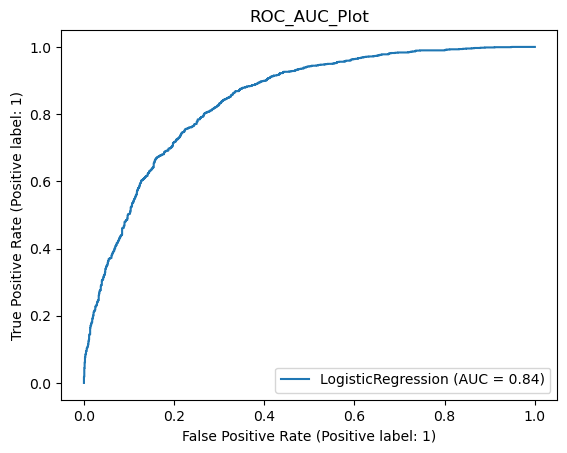

In [50]:
model(classifier_lr,x_train,y_train,x_test,y_test)

### Decision tree

In [51]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

Cross Validation Score :  84.49%
ROC_AUC Score :  76.74%


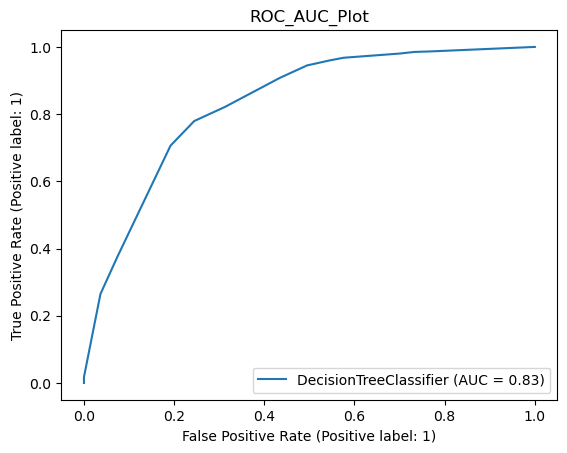

In [52]:
model(classifier_dt,x_train,y_train,x_test,y_test)

### Random forest

In [53]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

Cross Validation Score :  86.14%
ROC_AUC Score :  77.10%


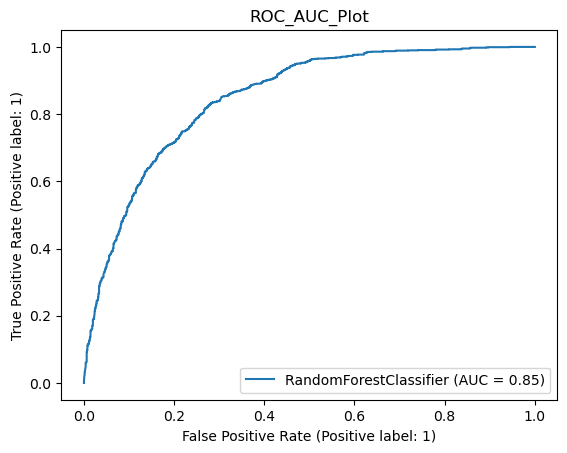

In [54]:
model(classifier_rf,x_train,y_train,x_test,y_test)

### XGBoost

In [55]:
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

Cross Validation Score :  90.58%
ROC_AUC Score :  82.05%


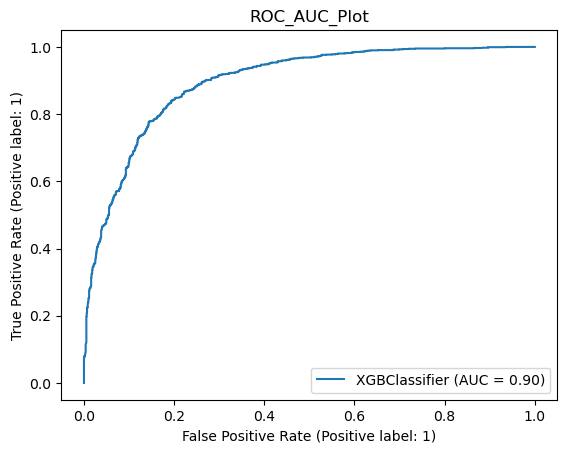

In [56]:
model(classifier_xgb,x_train,y_train,x_test,y_test)

### LightGBM

In [57]:
classifier_lgbm = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

Cross Validation Score :  90.72%
ROC_AUC Score :  82.17%


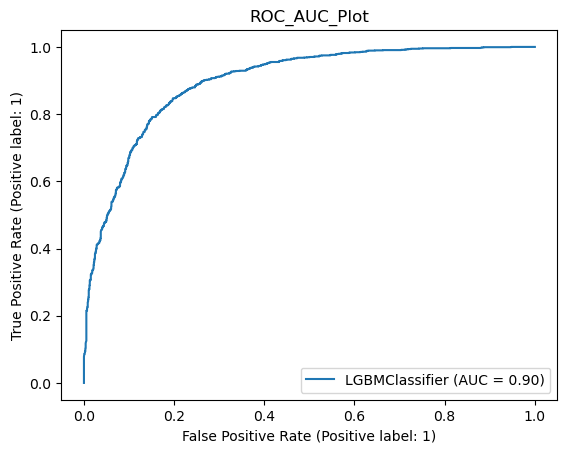

In [58]:
model(classifier_lgbm,x_train,y_train,x_test,y_test)

### Stacking Classifier 

In [59]:
stack = StackingClassifier(estimators = [('classifier_lr',classifier_lr),
                                         ('classifier_xgb',classifier_xgb),
                                         ('classifier_lgbm',classifier_lgbm),
                                         ('classifier_rf',classifier_rf),
                                         ('classifier_dt',classifier_dt)],
                           final_estimator = classifier_lgbm)

Cross Validation Score :  91.17%
ROC_AUC Score :  82.76%


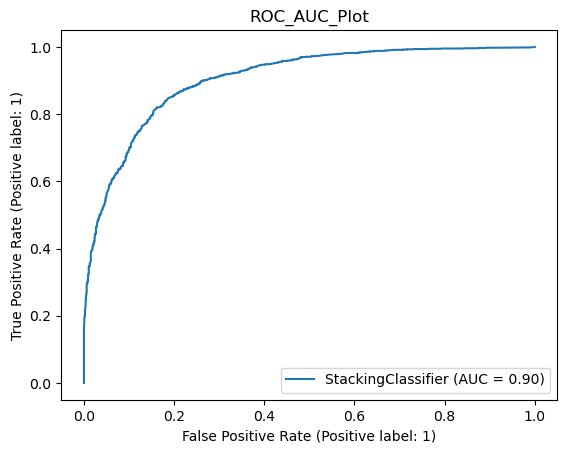

In [60]:
model(stack,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1312
           1       0.81      0.85      0.83      1270

    accuracy                           0.83      2582
   macro avg       0.83      0.83      0.83      2582
weighted avg       0.83      0.83      0.83      2582



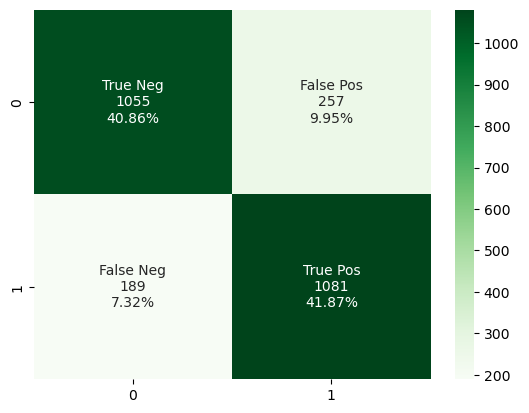

In [61]:
model_evaluation(stack,x_test,y_test)

In [62]:
df2 = df1.drop(columns='Churn', axis=1)
perm = PermutationImportance(stack, random_state=1234).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = df2.columns[1:].tolist())

Weight,Feature
0.0963 ± 0.0051,OnlineSecurity
0.0891 ± 0.0062,PaperlessBilling
0.0266 ± 0.0012,TotalCharges
0.0228 ± 0.0042,MonthlyCharges
0.0171 ± 0.0020,PaymentMethod
0.0145 ± 0.0028,tenure
0.0120 ± 0.0033,Contract
0.0074 ± 0.0018,Dependents
0.0063 ± 0.0005,Partner
0.0063 ± 0.0030,OnlineBackup


## Conclusiones

Se comenzó realizando una visualización de la base de datos en donde notamos que no existían filas duplicadas y el tipo de datos de la columna “TotalCharges” era erróneo, al corregir el tipo de dato de este ultimo pasamos a revisar los valores ausentes o nulos. Encontramos un 0,02% de filas con valores nulos los cuales fueron eliminados al ser un porcentaje tan bajo y no afectar a los resultados que se fueran a obtener en el proyecto.

Posteriormente se crearon funciones que se utilizarían durante el EDA y el modelado. Continuamos realizando el análisis exploratorio de los datos, en donde notamos que las características de “genre”, “PhoneService”, “MultipleLines”, “StreamingTV” y “StreamingMovies” no tenían una mayor relación con la tasa de fuga de los clientes. Por otra notamos que los clientes de tercera edad tienen una mayor tendencia a abandonar los servicios al igual que los clientes que no tienen pareja ni dependientes. Continuando con el análisis, los servicios de “OnlineSecurity”, “OnlineBackup”, “DeviceProtection” y “TechSupport” sirven como un aliciente para fomentar la permanencia de los clientes en el servicio. Con respecto al pago de los productos, la mayor parte de los clientes que abandonan el servicio poseían un contrato “month-to-month”y un medio de pago a través de “electronic chech” por lo que a estos puntos se les debería prestar una mayor atención. Finalmente, la mayor fuga de clientes de da durante el primer mes de uso de los servicios, cuando no han hecho un mayor gasto en los mismos.

Procedimos a transformar las variables categóricas a numéricas para un correcto funcionamiento de modelos como la regresión logística, se realizó una selección de variables aplicando a las variables categóricas una prueba chi-cuadrado y a las numéricas una prueba ANOVA y finalmente realizamos un balance de los datos. Se definió la métrica principal de evaluación como roc_auc por su facilidad para evaluar el performance del modelo y se procedió a entrenar un modelo de regresión logística, árbol de decisión, bosque aleatorio, xgboost y lightgbm, para proceder a crear un modelo de ensamble a partir de los anteriormente nombrados. Finalmente obtuvimos un modelo con un roc_auc con validación cruzada de un 91% y un recall promedio de un 83%.

### Solicitudes

En base a lo analizado en el proyecto para minimizar la probabilidad de fuga:

-Con respecto al TechSupport, pudimos observar que la gente que posee este servicio tiene un ratio de casi un quinto de probabilidad de fuga con respecto a quienes poseen servicio de internet y no poseen este servicio. En base a lo anterior es que debiera utilizarse el mismo como un gancho para las personas que posean servicio de internet y se encuentren con probabilidad de fuga de la empresa para reducir la probabilidad de la misma.

-Con respecto al tipo de contrato, el contrato month-month tenía más de 5 veces probabilidad de fuga en comparación a los contratos anuales o cada 2 años, es por eso que deben favorecerse estos dos últimos tipos de contrato, ya sea en base a promociones o descuentos con el objetivo de amarrar al cliente por un largo periodo de tiempo y así evitar la gran mayoría de las fugas que se dan en los primeros meses de servicio.

-En cuanto a los "MonthlyCharges", encontramos un rango de precio que tenía una mayor probabilidad de que ocurriera fuga pero a su vez pudimos observar que en clientes con mayor antigüedad esta probabilidad disminuye, en base a lo anterior se podrían otorgar descuentos en el cobro mensual por un periodo de tiempo fijo para que el cliente alcance el punto de antigüedad en que disminuye su probabilidad de abandono.